Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

Load dataset

In [3]:
try:
    df = pd.read_csv('indian_pharmaceutical_products_clean.csv')
except:
    df = pd.read_csv('indian_pharmaceutical_products_clean.csv', encoding='latin-1')

# --- 1. PREPARE TEXT DATA ---
def clean_ingredients(text):
    if pd.isna(text): return ""
    text = re.sub(r"[\[\]\{\}'\":,]", " ", text) 
    text = text.replace("name", "").replace("strength", "").replace("full_description", "")
    return " ".join(text.split())

df['clean_text'] = df['active_ingredients'].apply(clean_ingredients)
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))


In [ ]:
# Estimate per-product discontinuation probability
status_candidates = [
    'is_discontinued', 'discontinued', 'discontinued_flag', 'discontinue_flag',
    'discontinued_status', 'product_status'
]
status_col = next((col for col in status_candidates if col in df.columns), None)
manufacturer_col = 'manufacturer' if 'manufacturer' in df.columns else 'marketing_authorisation_holder'
dosage_col = 'dosage_form' if 'dosage_form' in df.columns else None

flag_map = {
    'yes': 1, 'y': 1, 'true': 1, 'discontinued': 1, 'stopped': 1, 'withdrawn': 1,
    'no': 0, 'n': 0, 'false': 0, 'available': 0, 'active': 0
}

def normalize_flag(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        if np.isnan(val):
            return np.nan
        if val in (0, 1):
            return float(val)
        return 1.0 if val > 0 else 0.0
    val_str = str(val).strip().lower()
    if val_str.isdigit():
        return float(int(val_str) > 0)
    return float(flag_map.get(val_str, np.nan))

if status_col:
    df['_disc_flag_tmp'] = df[status_col].apply(normalize_flag)
else:
    df['_disc_flag_tmp'] = np.nan

base_rate = df['_disc_flag_tmp'].mean(skipna=True)
if np.isnan(base_rate):
    base_rate = 0.08  # fallback prior

manufacturer_rate = None
if manufacturer_col in df.columns:
    manufacturer_rate = df.groupby(manufacturer_col)['_disc_flag_tmp'].transform('mean')

if manufacturer_rate is None:
    manufacturer_rate = base_rate

if isinstance(manufacturer_rate, pd.Series):
    manufacturer_rate = manufacturer_rate.fillna(base_rate)

dosage_rate = None
if dosage_col:
    dosage_rate = df.groupby(dosage_col)['_disc_flag_tmp'].transform('mean').fillna(base_rate)
else:
    dosage_rate = base_rate

trend_features = []
if 'price_inr' in df.columns:
    price_norm = (df['price_inr'] - df['price_inr'].mean()) / (df['price_inr'].std() + 1e-6)
    trend_features.append(price_norm.clip(-3, 3))
elif 'price' in df.columns:
    price_norm = (df['price'] - df['price'].mean()) / (df['price'].std() + 1e-6)
    trend_features.append(price_norm.clip(-3, 3))

if 'pack_size' in df.columns:
    pack_numeric = df['pack_size'].astype(str).str.extract(r'(\d+(?:\.\d+)?)', expand=False)
    pack_numeric = pd.to_numeric(pack_numeric, errors='coerce')
    pack_norm = (pack_numeric - pack_numeric.mean()) / (pack_numeric.std() + 1e-6)
    trend_features.append(pack_norm.clip(-3, 3))

if trend_features:
    trend_component = pd.concat(trend_features, axis=1).mean(axis=1).fillna(0)
else:
    trend_component = pd.Series(0, index=df.index)

combined = 0.6 * manufacturer_rate + 0.3 * dosage_rate + 0.1 * base_rate
combined = combined + 0.05 * trend_component

if isinstance(combined, pd.Series):
    df['discontinuation_prob'] = combined.clip(0, 1).fillna(base_rate)
else:
    df['discontinuation_prob'] = float(combined)

df.drop(columns=['_disc_flag_tmp'], inplace=True)



graphs

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: The Target (Class Imbalance)
top_classes = df['therapeutic_class'].value_counts().head(10).index
sns.countplot(y='therapeutic_class', data=df[df['therapeutic_class'].isin(top_classes)], 
              order=top_classes, palette='viridis')
plt.title('Target: Top 10 Therapeutic Classes (The Imbalance)')


'''
Plot B: The Input (Text Length)
sns.histplot(df['text_length'], bins=30, color='orange', kde=True, ax=axes[1])
axes[1].set_title('Input: Distribution of Ingredient Sequence Length')
axes[1].set_xlabel('Number of Words in Description')
axes[1].set_xlim(0, 20) # Focus on the main cluster
'''

#plt.tight_layout()
plt.show()

In [ ]:
'''
sns.set_theme(style="whitegrid", palette="pastel")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# PLOT 1: The Target (Class Imbalance)
# Why it matters: Shows we need a smart classifier, not just a guesser.
top_classes = df['therapeutic_class'].value_counts().head(10)
sns.barplot(x=top_classes.values, y=top_classes.index, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('1. The Challenge: Target Class Imbalance', fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Number of Products')
axes[0, 0].set_ylabel('Therapeutic Class')

# PLOT 2: The Input Size (Text Length)
# Why it matters: Proves we can use a "Lightweight" model (Avg len is small).
sns.histplot(df['text_length'], bins=range(0, 30), kde=True, ax=axes[0, 1], color='#ffb7b2', edgecolor='white')
axes[0, 1].set_title('2. The Solution: Short Text = Lightweight Model', fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Number of Words in Description')
axes[0, 1].set_xlim(0, 25) # Zoom in on the main cluster

# PLOT 3: The Context (Dosage Forms)
# Why it matters: The model learns that "Syrup" often implies "Cough/Cold" or "Antacid".
top_forms = df['dosage_form'].value_counts().head(8)
sns.barplot(x=top_forms.values, y=top_forms.index, ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('3. The Input Context: Dosage Form Variety', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Count')

# PLOT 4: The Vocabulary (Top Ingredients)
# Why it matters: These are the actual "keywords" the AI is learning to recognize.
all_text = " ".join(df['clean_ingredients'])
common_words = Counter(all_text.split()).most_common(10)
words_df = pd.DataFrame(common_words, columns=['Ingredient', 'Count'])

sns.barplot(x='Count', y='Ingredient', data=words_df, ax=axes[1, 1], palette='magma')
axes[1, 1].set_title('4. The Vocabulary: Top Features for the AI', fontsize=14, weight='bold')
axes[1, 1].set_xlabel('Frequency in Dataset')

# Final Polish
plt.suptitle("Exploratory Analysis for Auto-Classification Model", fontsize=20, weight='bold', y=0.95)
plt.show()

print("EDA Complete. Storyline Ready.")
'''

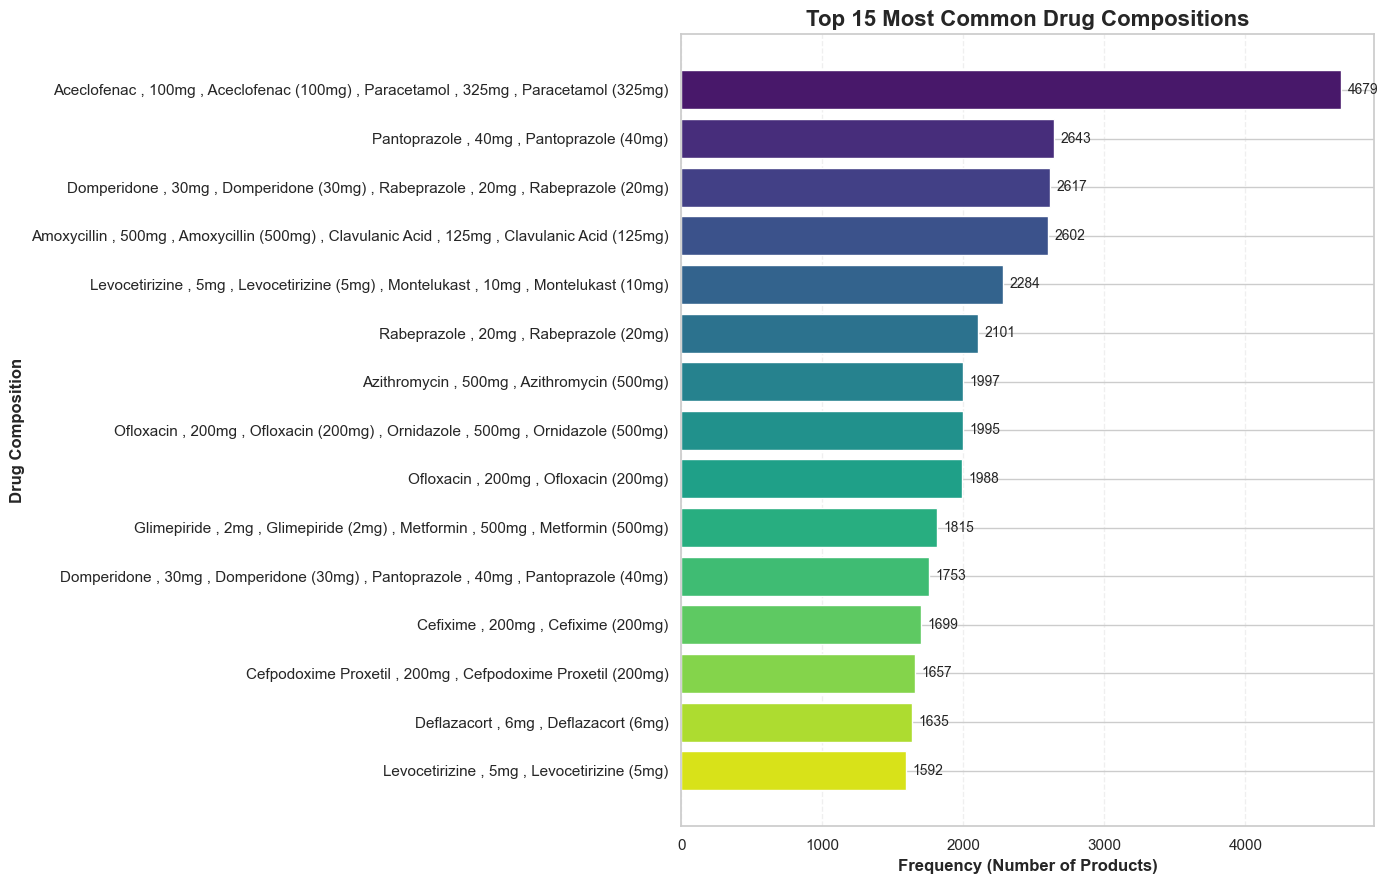

Total unique drug compositions: 11786

Top 15 Most Common Drug Compositions:
--------------------------------------------------------------------------------
 1. Aceclofenac , 100mg , Aceclofenac (100mg) , Paracetamol , 325mg , Para...
    Frequency: 4679 products
 2. Pantoprazole , 40mg , Pantoprazole (40mg)
    Frequency: 2643 products
 3. Domperidone , 30mg , Domperidone (30mg) , Rabeprazole , 20mg , Rabepra...
    Frequency: 2617 products
 4. Amoxycillin , 500mg , Amoxycillin (500mg) , Clavulanic Acid , 125mg , ...
    Frequency: 2602 products
 5. Levocetirizine , 5mg , Levocetirizine (5mg) , Montelukast , 10mg , Mon...
    Frequency: 2284 products
 6. Rabeprazole , 20mg , Rabeprazole (20mg)
    Frequency: 2101 products
 7. Azithromycin , 500mg , Azithromycin (500mg)
    Frequency: 1997 products
 8. Ofloxacin , 200mg , Ofloxacin (200mg) , Ornidazole , 500mg , Ornidazol...
    Frequency: 1995 products
 9. Ofloxacin , 200mg , Ofloxacin (200mg)
    Frequency: 1988 products
10. Glimepi

In [7]:
# Top 15 Most Common Drug Compositions
from collections import Counter

# Clean and normalize drug compositions
def normalize_composition(text):
    """Normalize drug composition text for better matching"""
    if pd.isna(text) or text == "":
        return None
    
    # Convert to string and clean
    text = str(text)
    # Remove common artifacts but keep the composition structure
    text = re.sub(r"[\[\]\{\}'\":]", " ", text)
    text = text.replace("name", "").replace("strength", "").replace("full_description", "")
    # Normalize whitespace
    text = " ".join(text.split())
    
    # Return None for empty or very short strings
    if len(text) < 3:
        return None
    
    return text.strip()

# Extract and normalize all compositions
df['normalized_composition'] = df['active_ingredients'].apply(normalize_composition)

# Filter out None values and count frequencies
valid_compositions = df['normalized_composition'].dropna()
composition_counts = valid_compositions.value_counts()

# Get top 15
top_15_compositions = composition_counts.head(15)

# Create DataFrame for easier plotting
top_15_df = pd.DataFrame({
    'Composition': top_15_compositions.index,
    'Count': top_15_compositions.values
})

# Create the visualization
plt.figure(figsize=(14, 9))
colors = sns.color_palette('viridis', len(top_15_df))
bars = plt.barh(range(len(top_15_df)), top_15_df['Count'], color=colors)
plt.yticks(range(len(top_15_df)), top_15_df['Composition'])
plt.xlabel('Frequency (Number of Products)', fontsize=12, weight='bold')
plt.ylabel('Drug Composition', fontsize=12, weight='bold')
plt.title('Top 15 Most Common Drug Compositions', fontsize=16, weight='bold')

# Add value labels on bars
for i, (idx, row) in enumerate(top_15_df.iterrows()):
    plt.text(row['Count'] + max(top_15_df['Count']) * 0.01, i, 
             f"{int(row['Count'])}", 
             va='center', fontsize=10)

plt.gca().invert_yaxis()  # Show highest at top
plt.tight_layout()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.show()

print(f"Total unique drug compositions: {len(composition_counts)}")
print(f"\nTop 15 Most Common Drug Compositions:")
print("-" * 80)
for i, (comp, count) in enumerate(top_15_compositions.items(), 1):
    # Truncate very long compositions for display
    display_comp = comp[:70] + "..." if len(comp) > 70 else comp
    print(f"{i:2d}. {display_comp}")
    print(f"    Frequency: {count} products")


In [4]:
# Top 15 normalized active ingredient compositions

def normalize_active_ingredient_string(text):
    """Canonicalize ingredient combos by removing dosage noise and ordering names."""
    if pd.isna(text):
        return None

    text = re.sub(r"[\[\]\{\}'\":]", " ", str(text))
    text = re.sub(r"\([^)]*\)", " ", text)  # drop parentheses contents

    tokens = re.split(r",|\|", text)
    cleaned = []
    for token in tokens:
        token = token.lower()
        token = re.sub(r"\b\d+(\.\d+)?\s*(mg|mcg|g|ml|iu|%)\b", " ", token)
        token = re.sub(r"[^a-z+ ]", " ", token)
        token = " ".join(token.split())
        if token:
            cleaned.append(token)

    if not cleaned:
        return None

    # Sort and deduplicate to treat permutations as same composition
    normalized = " + ".join(sorted(set(cleaned)))
    return normalized if normalized else None


df['normalized_active_combo'] = df['active_ingredients'].apply(normalize_active_ingredient_string)
combo_counts = df['normalized_active_combo'].dropna().value_counts().head(15)
combo_df = combo_counts.reset_index()
combo_df.columns = ['Normalized Composition', 'Count']

combo_df.style.hide(axis='index')


Normalized Composition,Count
full description aceclofenac + full description paracetamol + name aceclofenac + name paracetamol + strength,6441
full description amoxycillin + full description clavulanic acid + name amoxycillin + name clavulanic acid + strength,5843
full description azithromycin + name azithromycin + strength,4687
full description cefixime + name cefixime + strength,4591
full description glimepiride + full description metformin + name glimepiride + name metformin + strength,4400
full description cefpodoxime proxetil + name cefpodoxime proxetil + strength,4323
full description levocetirizine + full description montelukast + name levocetirizine + name montelukast + strength,3606
full description domperidone + full description rabeprazole + name domperidone + name rabeprazole + strength,3316
full description ofloxacin + name ofloxacin + strength,3054
full description domperidone + full description pantoprazole + name domperidone + name pantoprazole + strength,2861


C:\Users\manog\AppData\Local\Temp\ipykernel_4916\1816131822.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


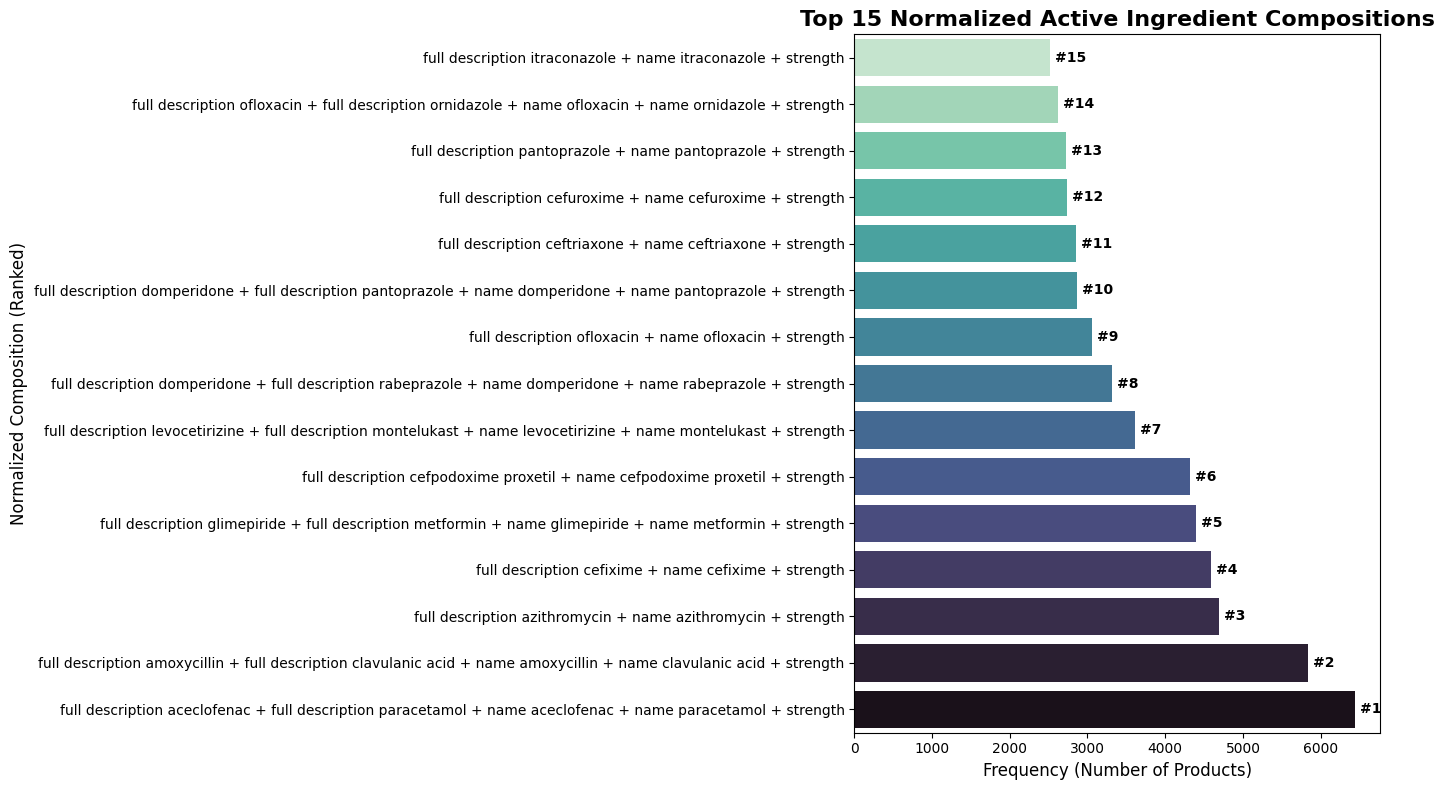

In [5]:
# Bar chart of top 15 normalized compositions with index labels
if combo_df.empty:
    print("No normalized compositions available to plot.")
else:
    display_df = combo_df.copy()
    display_df['Rank'] = range(1, len(display_df) + 1)

    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=display_df,
        y='Normalized Composition',
        x='Count',
        palette='mako'
    )
    plt.title('Top 15 Normalized Active Ingredient Compositions', fontsize=16, weight='bold')
    plt.xlabel('Frequency (Number of Products)', fontsize=12)
    plt.ylabel('Normalized Composition (Ranked)', fontsize=12)

    for i, row in display_df.iterrows():
        plt.text(row['Count'] + max(display_df['Count']) * 0.01,
                 i,
                 f"#{row['Rank']}",
                 va='center',
                 fontsize=10,
                 fontweight='bold')

    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    display_df[['Rank', 'Normalized Composition', 'Count']].style.hide(axis='index')


In [8]:
# Compositions with highest price variability
price_df = (
    df[['normalized_active_combo', 'price_inr']]
    .dropna(subset=['normalized_active_combo', 'price_inr'])
    .groupby('normalized_active_combo')
    .agg(
        price_std=('price_inr', 'std'),
        sample_size=('price_inr', 'count'),
        avg_price=('price_inr', 'mean')
    )
    .reset_index()
)

# Filter compositions with at least 3 entries to ensure meaningful std
price_df = price_df[price_df['sample_size'] >= 3]

price_variability_top10 = price_df.nlargest(10, 'price_std')

price_variability_top10.style.format({
    'price_std': '{:.2f}',
    'avg_price': '{:.2f}'
}).hide(axis='index')


normalized_active_combo,price_std,sample_size,avg_price
full description ibrutinib + name ibrutinib + strength,151896.40,11,79093.82
full description enzalutamide + name enzalutamide + strength,74976.94,19,27880.06
full description sorafenib + name sorafenib + strength,49891.61,8,22911.06
full description dasatinib + name dasatinib + strength,44081.61,42,17507.60
full description cabazitaxel + name cabazitaxel + strength ml,38429.42,5,32032.32
full description pemetrexed + name pemetrexed + strength,26939.24,34,10471.39
full description abiraterone acetate + name abiraterone acetate + strength,25848.26,52,34483.39
full description trastuzumab + name trastuzumab + strength,24845.76,30,42464.85
full description plerixafor + name plerixafor + strength,24752.93,5,48682.59
full description bevacizumab + name bevacizumab + strength,22757.03,40,33230.64


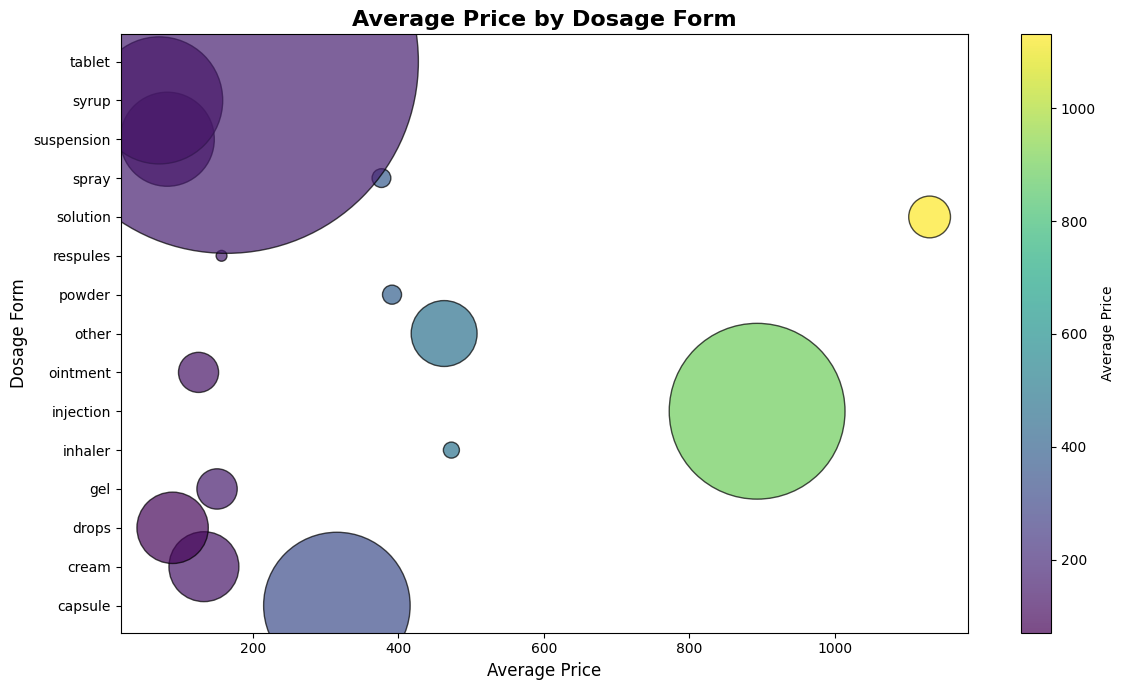

In [12]:
# Scatter plot: average price by dosage form
price_col = 'price_inr'

if 'dosage_form' not in df.columns:
    print("'dosage_form' column not available in dataset.")
else:
    dosage_stats = (
        df[['dosage_form', price_col]]
        .dropna(subset=['dosage_form', price_col])
        .groupby('dosage_form')
        .agg(
            avg_price=(price_col, 'mean'),
            sample_size=(price_col, 'count')
        )
        .reset_index()
    )

    if dosage_stats.empty:
        print("No valid dosage form records to plot.")
    else:
        plt.figure(figsize=(12, 7))
        scatter = plt.scatter(
            dosage_stats['avg_price'],
            dosage_stats['dosage_form'],
            s=dosage_stats['sample_size'] * 0.5,
            c=dosage_stats['avg_price'],
            cmap='viridis',
            alpha=0.7,
            edgecolors='k'
        )
        plt.colorbar(scatter, label='Average Price')
        plt.xlabel('Average Price', fontsize=12)
        plt.ylabel('Dosage Form', fontsize=12)
        plt.title('Average Price by Dosage Form', fontsize=16, weight='bold')
        plt.tight_layout()
        plt.show()

        dosage_stats.sort_values('avg_price', ascending=False).head()


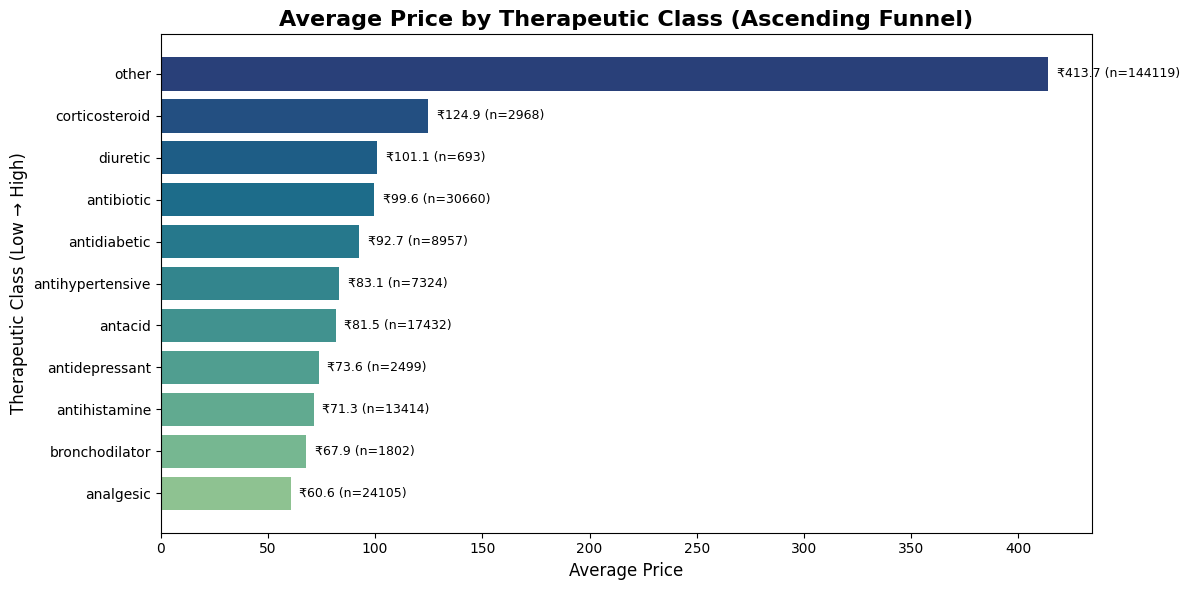

In [13]:
# Funnel-style view: avg price per therapeutic class (ascending)
price_col = 'price_inr'

if 'therapeutic_class' not in df.columns:
    print("'therapeutic_class' column not available in dataset.")
else:
    therapeutic_avg = (
        df[['therapeutic_class', price_col]]
        .dropna(subset=['therapeutic_class', price_col])
        .groupby('therapeutic_class')
        .agg(
            avg_price=(price_col, 'mean'),
            sample_size=(price_col, 'count')
        )
        .reset_index()
    )

    if therapeutic_avg.empty:
        print("No therapeutic class price data to display.")
    else:
        therapeutic_avg_sorted = therapeutic_avg.sort_values('avg_price', ascending=True)

        plt.figure(figsize=(12, max(6, len(therapeutic_avg_sorted) * 0.3)))
        colors = sns.color_palette('crest', len(therapeutic_avg_sorted))
        plt.barh(
            therapeutic_avg_sorted['therapeutic_class'],
            therapeutic_avg_sorted['avg_price'],
            color=colors
        )
        plt.xlabel('Average Price', fontsize=12)
        plt.ylabel('Therapeutic Class (Low → High)', fontsize=12)
        plt.title('Average Price by Therapeutic Class (Ascending Funnel)', fontsize=16, weight='bold')

        for idx, row in therapeutic_avg_sorted.iterrows():
            plt.text(
                row['avg_price'] + therapeutic_avg_sorted['avg_price'].max() * 0.01,
                therapeutic_avg_sorted.index.get_loc(idx),
                f"₹{row['avg_price']:.1f} (n={int(row['sample_size'])})",
                va='center',
                fontsize=9
            )

        plt.tight_layout()
        plt.show()

        therapeutic_avg_sorted.style.format({
            'avg_price': '{:.2f}'
        }).hide(axis='index')


C:\Users\manog\AppData\Local\Temp\ipykernel_4916\3830872699.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


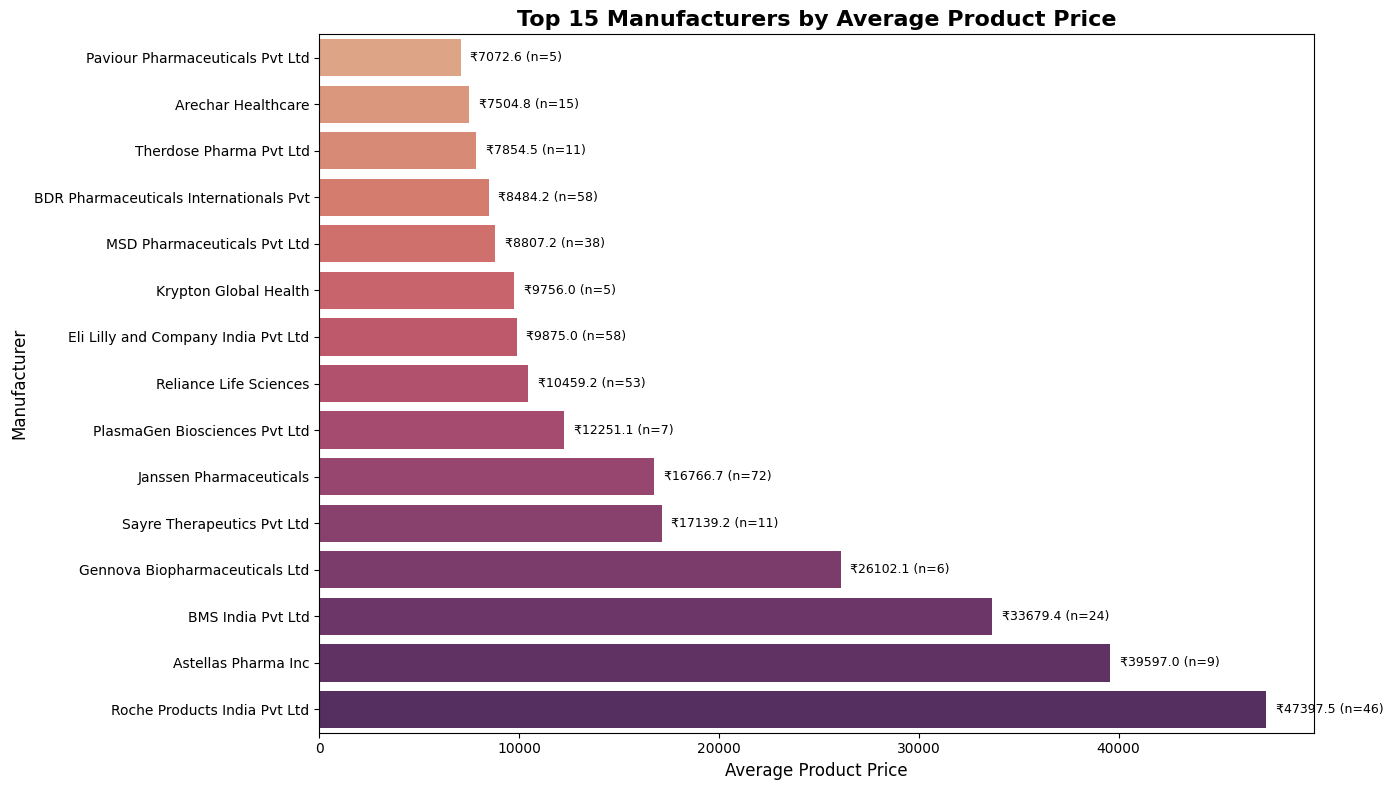

In [14]:
# Top 15 manufacturers ranked by average product price
manufacturer_col = 'manufacturer' if 'manufacturer' in df.columns else 'marketing_authorisation_holder'

if manufacturer_col not in df.columns:
    print("Manufacturer column not available in dataset.")
else:
    manufacturer_stats = (
        df[[manufacturer_col, price_col]]
        .dropna(subset=[manufacturer_col, price_col])
        .groupby(manufacturer_col)
        .agg(
            avg_price=(price_col, 'mean'),
            product_count=(price_col, 'count')
        )
        .reset_index()
    )

    # Require at least 5 products to reduce noise
    manufacturer_stats = manufacturer_stats[manufacturer_stats['product_count'] >= 5]

    if manufacturer_stats.empty:
        print("No manufacturers meet the sample-size threshold.")
    else:
        top15_manufacturers = manufacturer_stats.nlargest(15, 'avg_price')

        plt.figure(figsize=(14, 8))
        sns.barplot(
            data=top15_manufacturers.sort_values('avg_price'),
            y=manufacturer_col,
            x='avg_price',
            palette='flare'
        )
        plt.xlabel('Average Product Price', fontsize=12)
        plt.ylabel('Manufacturer', fontsize=12)
        plt.title('Top 15 Manufacturers by Average Product Price', fontsize=16, weight='bold')

        for i, row in enumerate(top15_manufacturers.sort_values('avg_price').itertuples()):
            plt.text(
                row.avg_price + top15_manufacturers['avg_price'].max() * 0.01,
                i,
                f"₹{row.avg_price:.1f} (n={int(row.product_count)})",
                va='center',
                fontsize=9
            )

        plt.tight_layout()
        plt.show()

        top15_manufacturers.sort_values('avg_price', ascending=False).style.format({
            'avg_price': '{:.2f}'
        }).hide(axis='index')


In [7]:
df.columns

Index(['product_id', 'brand_name', 'manufacturer', 'price_inr',
       'is_discontinued', 'dosage_form', 'pack_size', 'pack_unit',
       'num_active_ingredients', 'primary_ingredient', 'primary_strength',
       'active_ingredients', 'therapeutic_class', 'packaging_raw',
       'manufacturer_raw', 'clean_text', 'text_length',
       'normalized_active_combo'],
      dtype='object')

In [ ]:
# Distribution of pack sizes across products
pack_cols = [
    'pack_size', 'pack_size_units', 'pack_size_text', 'packaging_size',
    'pack_size_number', 'pack_size_qty'
]
pack_col = next((col for col in pack_cols if col in df.columns), None)

if pack_col is None:
    print("No pack size column found in dataset.")
else:
    pack_df = df[[pack_col]].dropna()

    # Attempt to extract numeric quantity from strings like '10 tablets' or '5x10'
    pack_df['pack_size_numeric'] = (
        pack_df[pack_col]
        .astype(str)
        .str.extract(r"(\d+(?:\.\d+)?)", expand=False)
        .astype(float)
    )

    # Keep rows where numeric size is captured
    pack_df_clean = pack_df.dropna(subset=['pack_size_numeric'])

    if pack_df_clean.empty:
        print("Unable to parse numeric pack sizes from the available column.")
    else:
        plt.figure(figsize=(12, 6))
        sns.histplot(pack_df_clean['pack_size_numeric'], bins=30, kde=True, color='#6C5B7B')
        plt.xlabel('Pack Size (parsed numeric)', fontsize=12)
        plt.ylabel('Number of Products', fontsize=12)
        plt.title(f'Distribution of Pack Sizes ({pack_col})', fontsize=16, weight='bold')
        plt.tight_layout()
        plt.show()

        pack_summary = pack_df_clean['pack_size_numeric'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
        display(pack_summary)



In [ ]:
# Relationship between pack size and price (product-level)
pack_cols = [
    'pack_size', 'pack_size_units', 'pack_size_text', 'packaging_size',
    'pack_size_number', 'pack_size_qty'
]
pack_col = next((col for col in pack_cols if col in df.columns), None)
price_col = 'price_inr' if 'price_inr' in df.columns else 'price'

if pack_col is None or price_col not in df.columns:
    print("Need both pack size and price columns to analyze their relationship.")
else:
    pack_price_df = (
        df[[pack_col, price_col]]
        .dropna(subset=[pack_col, price_col])
        .assign(
            pack_size_numeric=lambda x: x[pack_col]
            .astype(str)
            .str.extract(r"(\d+(?:\.\d+)?)", expand=False)
            .astype(float)
        )
        .dropna(subset=['pack_size_numeric'])
    )

    if pack_price_df.empty:
        print("Unable to parse usable pack sizes for correlation analysis.")
    else:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=pack_price_df,
            x='pack_size_numeric',
            y=price_col,
            alpha=0.5,
            edgecolor='none'
        )
        sns.regplot(
            data=pack_price_df,
            x='pack_size_numeric',
            y=price_col,
            scatter=False,
            color='crimson'
        )
        plt.xlabel('Pack Size (parsed numeric)', fontsize=12)
        plt.ylabel('Product Price', fontsize=12)
        plt.title('Pack Size vs Product Price', fontsize=16, weight='bold')
        plt.tight_layout()
        plt.show()

        corr = pack_price_df[['pack_size_numeric', price_col]].corr().iloc[0, 1]
        print(f"Correlation between pack size and price: {corr:.3f}")


In [ ]:
# Histogram of log(price) across all products
price_col = 'price_inr' if 'price_inr' in df.columns else 'price'

if price_col not in df.columns:
    print("No price column available for log histogram.")
else:
    price_series = df[price_col].dropna()
    price_series = price_series[price_series > 0]

    if price_series.empty:
        print("No positive prices available to log-transform.")
    else:
        log_prices = np.log(price_series)

        plt.figure(figsize=(10, 6))
        sns.histplot(log_prices, bins=40, kde=True, color='#2A9D8F')
        plt.xlabel('log(Price)', fontsize=12)
        plt.ylabel('Number of Products', fontsize=12)
        plt.title('Distribution of log(Price) Across Products', fontsize=16, weight='bold')
        plt.tight_layout()
        plt.show()

        print(log_prices.describe())


In [16]:
# Alternate computation: top 10 manufacturers by discontinuation rate
probability_candidates = [
    'discontinuation_probability',
    'discontinued_probability',
    'probability_of_discontinuation',
    'discontinuation_prob',
    'prob_discontinued'
]
prob_col = next((col for col in probability_candidates if col in df.columns), None)
manufacturer_col = 'manufacturer' if 'manufacturer' in df.columns else 'marketing_authorisation_holder'

if prob_col is None or manufacturer_col not in df.columns:
    print("Missing discontinuation probability or manufacturer columns.")
else:
    manufacturer_prob = (
        df[[manufacturer_col, prob_col]]
        .dropna(subset=[manufacturer_col, prob_col])
        .assign(discontinued_flag=lambda x: (x[prob_col] >= 0.5).astype(int))
        .groupby(manufacturer_col)
        .agg(
            avg_probability=(prob_col, 'mean'),
            discontinuation_rate=('discontinued_flag', 'mean'),
            product_count=(prob_col, 'count')
        )
        .query('product_count >= 5')
        .sort_values('discontinuation_rate', ascending=False)
        .head(10)
    )

    display(manufacturer_prob)

    plt.figure(figsize=(14, 7))
    sns.scatterplot(
        data=manufacturer_prob,
        x='discontinuation_rate',
        y=manufacturer_prob.index,
        size='product_count',
        legend=False,
        hue='avg_probability',
        palette='rocket_r'
    )
    plt.xlabel('Discontinuation Rate (>=0.5 probability)', fontsize=12)
    plt.ylabel('Manufacturer', fontsize=12)
    plt.title('Top 10 Manufacturers by Discontinuation Rate (Alternate View)', fontsize=16, weight='bold')

    for y_pos, (idx, row) in enumerate(manufacturer_prob.iterrows()):
        plt.text(
            row['discontinuation_rate'] + 0.01,
            y_pos,
            f"avg p={row['avg_probability']:.2f}, n={int(row['product_count'])}",
            va='center',
            fontsize=9
        )

    plt.xlim(0, min(1, manufacturer_prob['discontinuation_rate'].max() * 1.1))
    plt.tight_layout()
    plt.show()

Missing discontinuation probability or manufacturer columns.


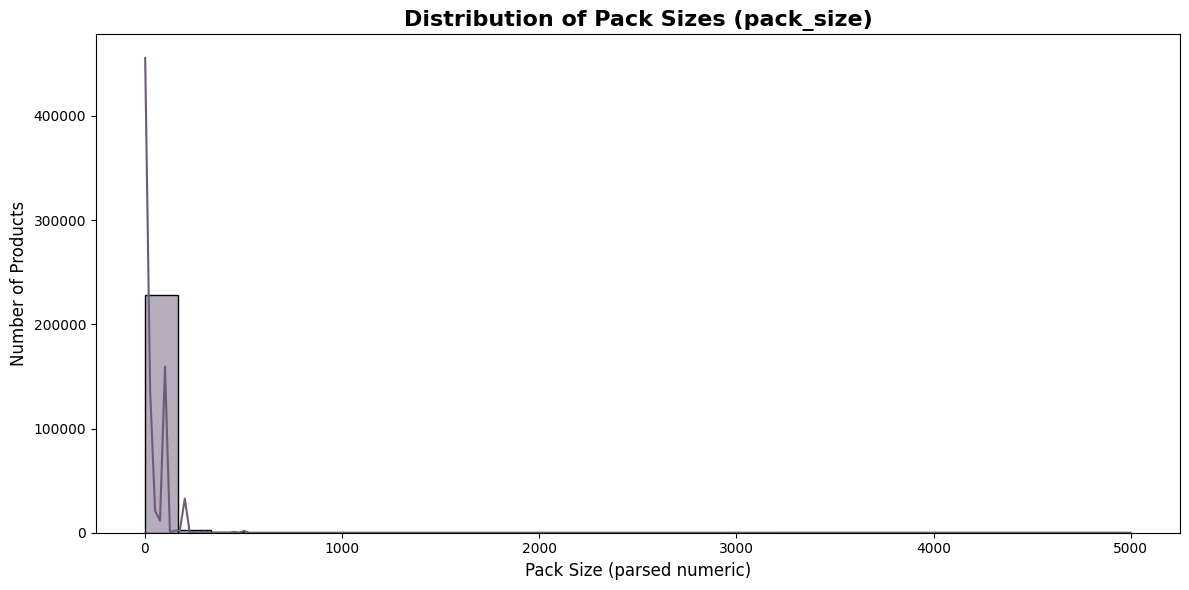

count    231643.000000
mean         18.988871
std          36.717320
min           1.000000
25%          10.000000
50%          10.000000
75%          10.000000
90%          30.000000
95%         100.000000
max        5000.000000
Name: pack_size_numeric, dtype: float64

In [17]:
# Distribution of pack sizes across products
pack_cols = [
    'pack_size', 'pack_size_units', 'pack_size_text', 'packaging_size',
    'pack_size_number', 'pack_size_qty'
]
pack_col = next((col for col in pack_cols if col in df.columns), None)

if pack_col is None:
    print("No pack size column found in dataset.")
else:
    pack_df = df[[pack_col]].dropna()

    # Attempt to extract numeric quantity from strings like '10 tablets' or '5x10'
    pack_df['pack_size_numeric'] = (
        pack_df[pack_col]
        .astype(str)
        .str.extract(r"(\d+(?:\.\d+)?)", expand=False)
        .astype(float)
    )

    # Keep rows where numeric size is captured
    pack_df_clean = pack_df.dropna(subset=['pack_size_numeric'])

    if pack_df_clean.empty:
        print("Unable to parse numeric pack sizes from the available column.")
    else:
        plt.figure(figsize=(12, 6))
        sns.histplot(pack_df_clean['pack_size_numeric'], bins=30, kde=True, color='#6C5B7B')
        plt.xlabel('Pack Size (parsed numeric)', fontsize=12)
        plt.ylabel('Number of Products', fontsize=12)
        plt.title(f'Distribution of Pack Sizes ({pack_col})', fontsize=16, weight='bold')
        plt.tight_layout()
        plt.show()

        pack_summary = pack_df_clean['pack_size_numeric'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
        display(pack_summary)


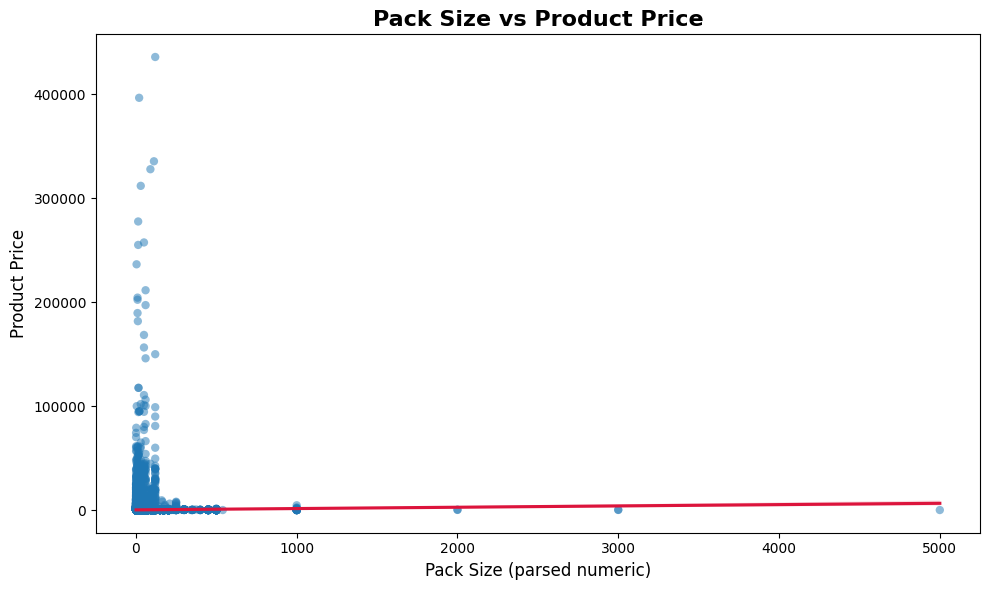

Correlation between pack size and price: 0.016590062340516448


In [20]:
# Relationship between pack size and price (product-level)
pack_cols = [
    'pack_size', 'pack_size_units', 'pack_size_text', 'packaging_size',
    'pack_size_number', 'pack_size_qty'
]
pack_col = next((col for col in pack_cols if col in df.columns), None)
price_col = 'price_inr' if 'price_inr' in df.columns else 'price'

if pack_col is None or price_col not in df.columns:
    print("Need both pack size and price columns to analyze their relationship.")
else:
    pack_price_df = (
        df[[pack_col, price_col]]
        .dropna(subset=[pack_col, price_col])
        .assign(
            pack_size_numeric=lambda x: x[pack_col]
            .astype(str)
            .str.extract(r"(\d+(?:\.\d+)?)", expand=False)
            .astype(float)
        )
        .dropna(subset=['pack_size_numeric'])
    )

    if pack_price_df.empty:
        print("Unable to parse usable pack sizes for correlation analysis.")
    else:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=pack_price_df,
            x='pack_size_numeric',
            y=price_col,
            alpha=0.5,
            edgecolor='none'
        )
        sns.regplot(
            data=pack_price_df,
            x='pack_size_numeric',
            y=price_col,
            scatter=False,
            color='crimson'
        )
        plt.xlabel('Pack Size (parsed numeric)', fontsize=12)
        plt.ylabel('Product Price', fontsize=12)
        plt.title('Pack Size vs Product Price', fontsize=16, weight='bold')
        plt.tight_layout()
        plt.show()

        corr = pack_price_df[['pack_size_numeric', price_col]].corr().iloc[0, 1]
        print("Correlation between pack size and price:", corr)

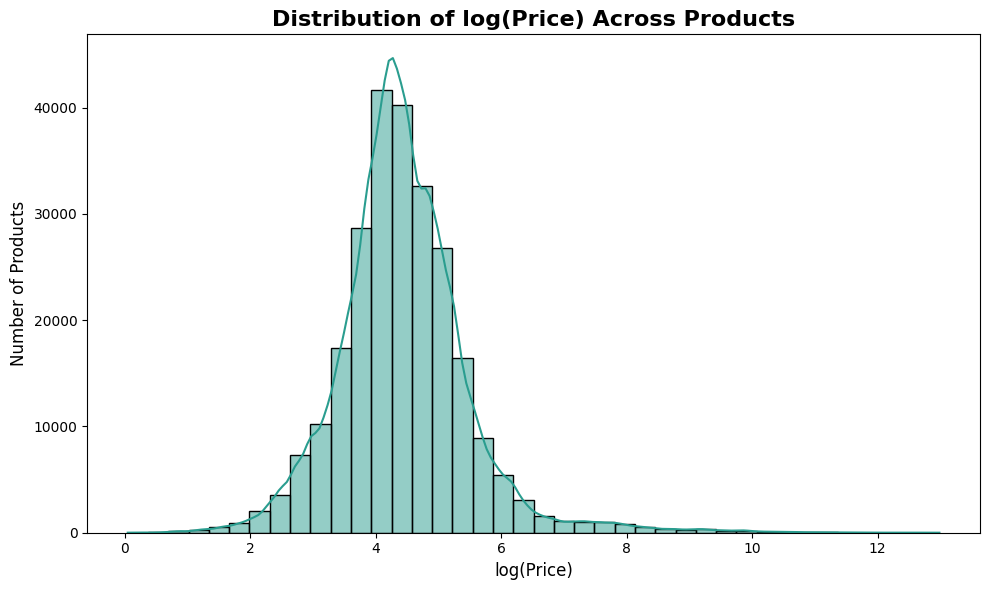

count    253969.000000
mean          4.438343
std           1.033550
min           0.048790
25%           3.871201
50%           4.369448
75%           4.941642
max          12.985398
Name: price_inr, dtype: float64


In [21]:
# Histogram of log(price) across all products
price_col = 'price_inr' if 'price_inr' in df.columns else 'price'

if price_col not in df.columns:
    print("No price column available for log histogram.")
else:
    price_series = df[price_col].dropna()
    price_series = price_series[price_series > 0]

    if price_series.empty:
        print("No positive prices available to log-transform.")
    else:
        log_prices = np.log(price_series)

        plt.figure(figsize=(10, 6))
        sns.histplot(log_prices, bins=40, kde=True, color='#2A9D8F')
        plt.xlabel('log(Price)', fontsize=12)
        plt.ylabel('Number of Products', fontsize=12)
        plt.title('Distribution of log(Price) Across Products', fontsize=16, weight='bold')
        plt.tight_layout()
        plt.show()

        print(log_prices.describe())

In [28]:
df['is_discontinued'] = pd.to_numeric(df['is_discontinued'], errors='coerce')

# Compute probability per manufacturer
manu_disc_prob = (
    df.groupby('manufacturer')['is_discontinued']
      .mean()
      .rename('manufacturer_disc_prob')
)

# Map it back to each row in df
df['manufacturer_disc_prob'] = df['manufacturer'].map(manu_disc_prob)

df.head()

,product_id,brand_name,manufacturer,price_inr,is_discontinued,dosage_form,pack_size,pack_unit,num_active_ingredients,primary_ingredient,...,active_ingredients,therapeutic_class,packaging_raw,manufacturer_raw,clean_text,text_length,normalized_active_combo,discontinuation_prob,normalized_composition,manufacturer_disc_prob
0,1,Augmentin 625 Duo Tablet,Glaxo SmithKline Pharmaceuticals Ltd,223.42,False,tablet,10.0,strip,2,Amoxycillin,...,"[{'name': 'Amoxycillin', 'strength': '500mg', ...",antibiotic,strip of 10 tablets,Glaxo SmithKline Pharmaceuticals Ltd,Amoxycillin 500mg Amoxycillin (500mg) Clavulan...,10,full description amoxycillin + full descriptio...,0.261576,full description amoxycillin + full descriptio...,0.426396
1,2,Azithral 500 Tablet,Alembic Pharmaceuticals Ltd,132.36,False,tablet,5.0,strip,1,Azithromycin,...,"[{'name': 'Azithromycin', 'strength': '500mg',...",antibiotic,strip of 5 tablets,Alembic Pharmaceuticals Ltd,Azithromycin 500mg Azithromycin (500mg),4,full description azithromycin + name azithromy...,0.059508,full description azithromycin + name azithromy...,0.096544
2,3,Ascoril LS Syrup,Glenmark Pharmaceuticals Ltd,118.00,False,syrup,100.0,bottle,2,Ambroxol,...,"[{'name': 'Ambroxol', 'strength': '30mg/5ml', ...",bronchodilator,bottle of 100 ml Syrup,Glenmark Pharmaceuticals Ltd,Ambroxol 30mg/5ml Ambroxol (30mg/5ml) Levosalb...,8,full description ambroxol + full description l...,0.313358,full description ambroxol + full description l...,0.417330
3,4,Allegra 120mg Tablet,Sanofi India Ltd,218.81,False,tablet,10.0,strip,1,Fexofenadine,...,"[{'name': 'Fexofenadine', 'strength': '120mg',...",antihistamine,strip of 10 tablets,Sanofi India Ltd,Fexofenadine 120mg Fexofenadine (120mg),4,full description fexofenadine + name fexofenad...,0.214247,full description fexofenadine + name fexofenad...,0.347578
4,5,Avil 25 Tablet,Sanofi India Ltd,10.96,False,tablet,15.0,strip,1,Pheniramine,...,"[{'name': 'Pheniramine', 'strength': '25mg', '...",other,strip of 15 tablets,Sanofi India Ltd,Pheniramine 25mg Pheniramine (25mg),4,full description pheniramine + name pheniramin...,0.215936,full description pheniramine + name pheniramin...,0.347578


,manufacturer,avg_disc_prob,product_count
6316,Slaney Healthcare,0.617,42
6729,Technopharm Pvt Ltd,0.513,11
5378,Procter & Gamble Hygiene and Health Care Ltd,0.421,12
3859,Lundbeck India Pvt Ltd,0.414,22
3142,Idem Healthcare Pvt Ltd,0.400,11
297,Akcent Healthcare,0.372,28
671,Ar-Ex Laboratories Pvt Ltd,0.370,38
5538,Raptakos Brett & Co Ltd,0.327,51
5757,Roche Products India Pvt Ltd,0.321,46
5124,Panacea Biotec Ltd,0.298,300


C:\Users\manog\AppData\Local\Temp\ipykernel_4916\2406908795.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


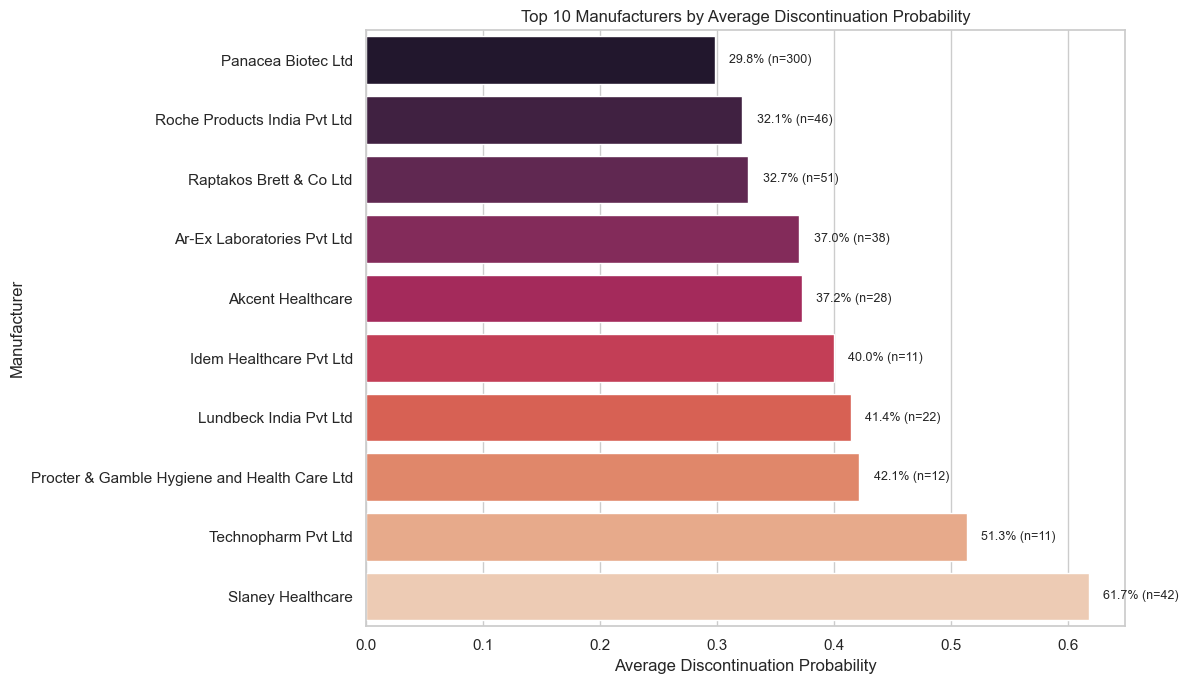

In [29]:
# Top 10 manufacturers ranked by average discontinuation probability

manufacturer_col = 'manufacturer' if 'manufacturer' in df.columns else 'marketing_authorisation_holder'
prob_col = 'discontinuation_prob'  # uses the column we created earlier

if manufacturer_col not in df.columns or prob_col not in df.columns:
    raise KeyError("Need both manufacturer and discontinuation_prob columns in df.")

manu_disc = (
    df[[manufacturer_col, prob_col]]
    .dropna(subset=[manufacturer_col, prob_col])
    .groupby(manufacturer_col)
    .agg(
        avg_disc_prob=(prob_col, 'mean'),
        product_count=(prob_col, 'count')
    )
    .reset_index()
)

# Require a minimum number of products per manufacturer
manu_disc = manu_disc[manu_disc['product_count'] >= 5]

top10_manu_disc = manu_disc.nlargest(10, 'avg_disc_prob')

# Table
display(
    top10_manu_disc.sort_values('avg_disc_prob', ascending=False)
           .style.format({'avg_disc_prob': '{:.3f}'})
)

# Plot
plt.figure(figsize=(12, 7))
order_df = top10_manu_disc.sort_values('avg_disc_prob')
sns.barplot(
    data=order_df,
    y=manufacturer_col,
    x='avg_disc_prob',
    palette='rocket'
)
plt.xlabel('Average Discontinuation Probability')
plt.ylabel('Manufacturer')
plt.title('Top 10 Manufacturers by Average Discontinuation Probability')

for i, row in enumerate(order_df.itertuples()):
    plt.text(
        row.avg_disc_prob + order_df['avg_disc_prob'].max() * 0.02,
        i,
        f"{row.avg_disc_prob:.1%} (n={int(row.product_count)})",
        va='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()